In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as stats
%matplotlib inline

In [2]:
data = pd.read_csv('data/Flight-Overbooking-Data.csv')

In [3]:
# Convert Date column to datetime. The rest of the data is clean
data["Date"] = pd.to_datetime(data["Date"])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
Date      730 non-null datetime64[ns]
Demand    730 non-null int64
Booked    730 non-null int64
Shows     730 non-null int64
Rate      730 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 28.6 KB


In [10]:
lam = data.Demand.mean()

In [6]:
data.Demand.var()

150.67873048086128

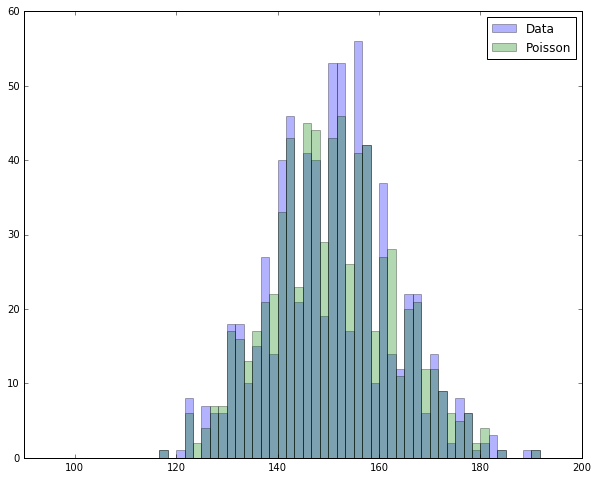

In [53]:
# Plot histogram of the demand data with generated sample Poisson data histogram to see how Poisson distribution fits

plt.figure(figsize=(10,8))
bins = np.linspace(80, 200, 73)
poisson = np.random.poisson(lam = lam, size = 730)
plt.hist(data["Demand"].values, bins, alpha = 0.3, label="Data")
plt.hist(poisson, bins, alpha = 0.3, label = "Poisson")

plt.xlim(90,200)
plt.legend(loc='upper right')
plt.show()